## 1. Setup and Imports

In [1]:
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms
from transformers import RobertaTokenizer, RobertaModel
from sklearn.cluster import KMeans

project_root = Path.cwd().parent
sys.path.insert(0, str(project_root))

plt.style.use('seaborn-v0_8-paper')
plt.rcParams['figure.dpi'] = 100

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"PyTorch {torch.__version__}")
print(f"Device: {device}")

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


PyTorch 1.12.1+cu102
Device: cuda


In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    allocated = torch.cuda.memory_allocated(0) / 1024**3
    reserved = torch.cuda.memory_reserved(0) / 1024**3
    print(f"GPU Memory: {allocated:.2f} GB allocated, {reserved:.2f} GB reserved")

GPU Memory: 0.00 GB allocated, 0.00 GB reserved


## 2. Model Architectures

Define the three classifier architectures:

- **V3**: Multimodal with explicit fuzzy feature integration
- **V4**: Fuzzy gating mechanism
- **V4.1**: Integrated gating variant

In [3]:
sys.path.insert(0, str(project_root / 'cerebrum_artis' / 'models' / 'v3_fuzzy_features'))
from train_v3 import MultimodalFuzzyClassifier as V3Model

class FuzzyGatingClassifier(nn.Module):
    """V4/V4.1: Neural network with fuzzy gating mechanism."""
    
    def __init__(self, num_classes=9, fuzzy_dim=7, dropout=0.3, freeze_resnet=True):
        super().__init__()
        
        resnet = models.resnet50(weights='IMAGENET1K_V1')
        self.visual_encoder = nn.Sequential(*list(resnet.children())[:-1])
        
        if freeze_resnet:
            for param in self.visual_encoder.parameters():
                param.requires_grad = False
        
        self.text_encoder = RobertaModel.from_pretrained('roberta-base')
        
        self.classifier = nn.Sequential(
            nn.Linear(2048 + 768, 1024),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, num_classes)
        )
    
    def forward(self, image, text_input_ids, text_attention_mask, fuzzy_features=None):
        visual_feats = self.visual_encoder(image).view(image.size(0), -1)
        text_output = self.text_encoder(input_ids=text_input_ids, attention_mask=text_attention_mask)
        text_feats = text_output.last_hidden_state[:, 0, :]
        combined = torch.cat([visual_feats, text_feats], dim=1)
        return self.classifier(combined)

V4Model = FuzzyGatingClassifier
V4_1Model = FuzzyGatingClassifier

EMOTION_LABELS = [
    'amusement', 'awe', 'contentment', 'excitement',
    'anger', 'disgust', 'fear', 'sadness', 'something else'
]

print(f"Models defined: V3, V4, V4.1")
print(f"Emotion classes: {len(EMOTION_LABELS)}")

Models defined: V3, V4, V4.1
Emotion classes: 9


## 3. Load Trained Models

Load the best checkpoints for each model variant.

In [4]:
import os
from dotenv import load_dotenv

load_dotenv()
CHECKPOINT_BASE = Path(os.getenv('CHECKPOINT_BASE'))

checkpoint_v3 = torch.load(CHECKPOINT_BASE / 'v3_fuzzy_features' / 'checkpoint_best.pt', map_location=device)
model_v3 = V3Model(num_classes=9)
model_v3.load_state_dict(checkpoint_v3['model_state_dict'])
model_v3 = model_v3.to(device).eval()

checkpoint_v4 = torch.load(CHECKPOINT_BASE / 'v4_fuzzy_gating' / 'checkpoint_best.pt', map_location=device)
model_v4 = V4Model(num_classes=9, fuzzy_dim=7)
model_v4.load_state_dict(checkpoint_v4['model_state_dict'])
model_v4 = model_v4.to(device).eval()

checkpoint_v41 = torch.load(CHECKPOINT_BASE / 'v4.1_integrated_gating' / 'checkpoint_best.pt', map_location=device)
model_v41 = V4_1Model(num_classes=9, fuzzy_dim=7)
model_v41.load_state_dict(checkpoint_v41['model_state_dict'])
model_v41 = model_v41.to(device).eval()

print("Loaded checkpoints:")
print(f"  V3: epoch {checkpoint_v3['epoch']}")
print(f"  V4: best checkpoint")
print(f"  V4.1: best checkpoint")

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/data/paloma/venvs/cerebrum-artis/l

Loaded checkpoints:
  V3: epoch 3
  V4: best checkpoint
  V4.1: best checkpoint


## 4. Load SAT Caption Generator

SAT (Show, Attend and Tell) model for generating emotion-conditioned captions.

In [5]:
import json
import pickle
from argparse import Namespace

sat_dir = project_root / 'garbage' / 'old_artemis-v2' / 'neural_speaker' / 'sat'
sat_checkpoint_path = project_root / 'garbage' / 'old_artemis-v2' / 'sat_logs' / 'sat_combined' / 'checkpoints' / 'best_model.pt'
sat_config_path = project_root / 'garbage' / 'old_artemis-v2' / 'sat_logs' / 'sat_combined' / 'config.json.txt'

sys.path.insert(0, str(sat_dir))

with open(sat_config_path, 'r') as f:
    sat_config = json.load(f)

checkpoint_sat = torch.load(sat_checkpoint_path, map_location=device)
vocab_size_from_ckpt = checkpoint_sat['model']['decoder.word_embedding.weight'].shape[0]

from artemis.neural_models.show_attend_tell import describe_model

vocab_path = project_root / 'data' / 'artemis' / 'dataset' / 'combined' / 'train' / 'vocabulary.pkl'
with open(vocab_path, 'rb') as f:
    vocab_obj_template = pickle.load(f)

class FakeVocab:
    def __init__(self, size, template):
        self.pad = template.pad if hasattr(template, 'pad') else 0
        self.sos = template.sos if hasattr(template, 'sos') else 1
        self.eos = template.eos if hasattr(template, 'eos') else 2
        self.unk = template.unk if hasattr(template, 'unk') else 3
        self._size = size
        self._template = template
    
    def __len__(self):
        return self._size
    
    def __call__(self, word):
        return self._template(word) if hasattr(self._template, '__call__') else self._template.word2idx.get(word, self.unk)

fake_vocab = FakeVocab(vocab_size_from_ckpt, vocab_obj_template)
args = Namespace(**sat_config)
sat_model = describe_model(fake_vocab, args)
sat_model.load_state_dict(checkpoint_sat['model'])
sat_model = sat_model.to(device).eval()
sat_vocab = vocab_obj_template

print(f"SAT model loaded")
print(f"  Vocabulary: {vocab_size_from_ckpt} tokens")
print(f"  Encoder: {sat_config.get('vis_encoder', 'resnet34')}")

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


SAT model loaded
  Vocabulary: 17440 tokens
  Encoder: resnet34


## 5. Load Sample Artwork

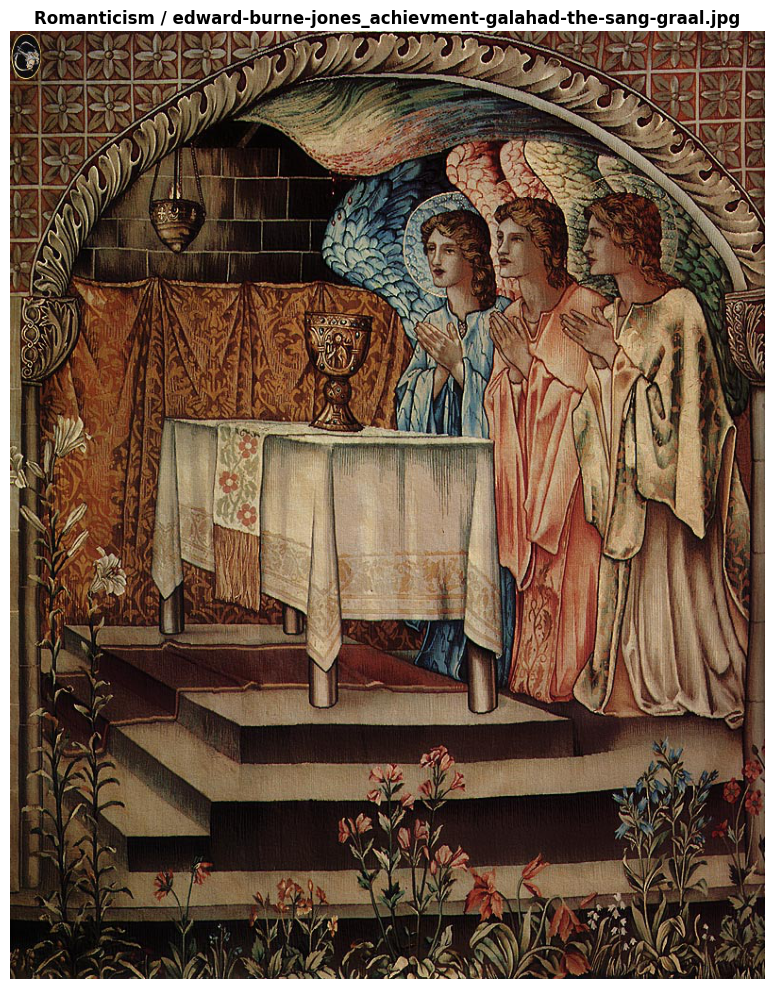

Image: edward-burne-jones_achievment-galahad-the-sang-graal.jpg
Style: Romanticism
Size: (800, 1005)
Tensor: torch.Size([1, 3, 224, 224])


In [79]:
import random

wikiart_dir = Path('/data/paloma/data/paintings/wikiart/Romanticism/')
all_images = list(wikiart_dir.rglob('*.jpg'))

sample_image_path = random.choice(all_images[:100])
image = Image.open(sample_image_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
image_tensor = transform(image).unsqueeze(0).to(device)

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(image)
ax.axis('off')
ax.set_title(f'{sample_image_path.parent.name} / {sample_image_path.name}',
            fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Image: {sample_image_path.name}")
print(f"Style: {sample_image_path.parent.name}")
print(f"Size: {image.size}")
print(f"Tensor: {image_tensor.shape}")

## 6. Extract Fuzzy Visual Features

Extract perceptually meaningful features in LAB color space:

- **Brightness**: Average L* (lightness)
- **Color Temperature**: Average a* (green-red axis)
- **Saturation**: Chroma (color intensity)
- **Color Harmony**: Variance in color distribution
- **Complexity**: Number of unique colors
- **Symmetry**: Placeholder for spatial analysis
- **Texture**: Color variance across channels

In [80]:
def extract_color_palette_lab(image_pil, n_colors=6):
    """Extract dominant colors using K-means in LAB color space."""
    img_array = np.array(image_pil.resize((150, 150)))
    img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
    lab = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2LAB).astype(np.float32)
    
    lab[:,:,0] = lab[:,:,0] * (100.0 / 255.0)
    lab[:,:,1] = lab[:,:,1] - 128.0
    lab[:,:,2] = lab[:,:,2] - 128.0
    
    pixels_lab = lab.reshape(-1, 3)
    kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
    kmeans.fit(pixels_lab)
    
    colors_lab = kmeans.cluster_centers_
    labels = kmeans.labels_
    proportions = np.bincount(labels) / len(labels)
    
    sorted_indices = np.argsort(proportions)[::-1]
    colors_lab = colors_lab[sorted_indices]
    proportions = proportions[sorted_indices]
    
    colors_rgb = []
    for lab_color in colors_lab:
        lab_pixel = lab_color.copy()
        lab_pixel[0] = lab_pixel[0] * (255.0 / 100.0)
        lab_pixel[1] = lab_pixel[1] + 128.0
        lab_pixel[2] = lab_pixel[2] + 128.0
        
        lab_img = np.uint8([[lab_pixel]])
        bgr_img = cv2.cvtColor(lab_img, cv2.COLOR_LAB2BGR)
        rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
        colors_rgb.append(rgb_img[0][0])
    
    colors_rgb = np.array(colors_rgb)
    return colors_rgb, proportions, colors_lab

colors_rgb, proportions, colors_lab = extract_color_palette_lab(image, n_colors=6)

print("Dominant colors (LAB space):")
for i, (rgb, lab, prop) in enumerate(zip(colors_rgb, colors_lab, proportions), 1):
    print(f"  {i}. RGB({rgb[0]:3d}, {rgb[1]:3d}, {rgb[2]:3d})  "
          f"LAB(L*={lab[0]:5.1f}, a*={lab[1]:+6.1f}, b*={lab[2]:+6.1f})  {prop:.1%}")

Dominant colors (LAB space):
  1. RGB( 70,  46,  34)  LAB(L*= 21.9, a*=  +9.6, b*= +12.7)  20.5%
  2. RGB( 32,  23,  22)  LAB(L*=  9.2, a*=  +4.6, b*=  +3.5)  19.9%
  3. RGB( 97,  80,  61)  LAB(L*= 35.4, a*=  +4.0, b*= +14.2)  17.5%
  4. RGB(140, 111,  81)  LAB(L*= 49.2, a*=  +7.1, b*= +21.1)  17.5%
  5. RGB(119,  69,  44)  LAB(L*= 35.0, a*= +19.9, b*= +24.9)  12.7%
  6. RGB(170, 149, 117)  LAB(L*= 62.9, a*=  +3.8, b*= +20.3)  11.8%


In [81]:
avg_L = np.average(colors_lab[:, 0], weights=proportions)
avg_a = np.average(colors_lab[:, 1], weights=proportions)
avg_b = np.average(colors_lab[:, 2], weights=proportions)
chroma = np.sqrt(avg_a**2 + avg_b**2)

brightness = avg_L / 100.0
color_temp = (avg_a + 127) / 254.0
saturation = chroma / 100.0
color_harmony = np.std(colors_lab[:, 1:3]) / 50.0
complexity = len(np.unique(colors_lab.astype(int), axis=0)) / 10.0
symmetry = 0.5
texture = np.mean(np.std(colors_lab, axis=0)) / 50.0

fuzzy_features_real = torch.tensor([[
    brightness, color_temp, saturation, color_harmony,
    complexity, symmetry, texture
]], dtype=torch.float32).to(device)

print("\nFuzzy Visual Features:")
print(f"  Brightness:        {brightness:.3f}")
print(f"  Color Temperature: {color_temp:.3f}")
print(f"  Saturation:        {saturation:.3f}")
print(f"  Color Harmony:     {color_harmony:.3f}")
print(f"  Complexity:        {complexity:.3f}")
print(f"  Symmetry:          {symmetry:.3f}")
print(f"  Texture:           {texture:.3f}")


Fuzzy Visual Features:
  Brightness:        0.330
  Color Temperature: 0.531
  Saturation:        0.169
  Color Harmony:     0.150
  Complexity:        0.600
  Symmetry:          0.500
  Texture:           0.200


## 7. Visual Emotion Classification

Classify emotion using visual features only (neutral caption to avoid textual bias).

In [82]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

caption_neutral = "A painting"
tokens = tokenizer(caption_neutral, max_length=128, padding='max_length',
                  truncation=True, return_tensors='pt')
input_ids = tokens['input_ids'].to(device)
attention_mask = tokens['attention_mask'].to(device)

with torch.no_grad():
    logits_v3 = model_v3(image_tensor, input_ids, attention_mask, fuzzy_features_real)
    logits_v4 = model_v4(image_tensor, input_ids, attention_mask, fuzzy_features_real)
    logits_v41 = model_v41(image_tensor, input_ids, attention_mask, fuzzy_features_real)
    
    probs_v3 = torch.softmax(logits_v3, dim=1)[0]
    probs_v4 = torch.softmax(logits_v4, dim=1)[0]
    probs_v41 = torch.softmax(logits_v41, dim=1)[0]
    
    ensemble_probs = (probs_v3 + probs_v4 + probs_v41) / 3.0
    pred_ensemble = torch.argmax(ensemble_probs).item()

emotion_detected = EMOTION_LABELS[pred_ensemble]
confidence = ensemble_probs[pred_ensemble].item()

print("Visual Emotion Classification:")
print(f"  Detected Emotion: {emotion_detected}")
print(f"  Confidence: {confidence:.1%}")
print(f"\nTop-3 Emotions:")
top3_indices = torch.argsort(ensemble_probs, descending=True)[:3]
for i, idx in enumerate(top3_indices, 1):
    print(f"  {i}. {EMOTION_LABELS[idx]:15s} {ensemble_probs[idx]:.1%}")

/data/paloma/venvs/cerebrum-artis/lib/python3.10/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Visual Emotion Classification:
  Detected Emotion: awe
  Confidence: 21.2%

Top-3 Emotions:
  1. awe             21.2%
  2. amusement       19.1%
  3. something else  18.9%


## 8. Generate Emotion-Conditioned Caption

Generate caption conditioned on the visually detected emotion.

In [83]:
from artemis.neural_models.attentive_decoder import sample_captions_beam_search

class SingleImageDataset:
    def __init__(self, image_tensor, emotion_onehot):
        self.image_tensor = image_tensor
        self.emotion_onehot = emotion_onehot
        self.batch_size = 1
    
    def __iter__(self):
        yield {'image': self.image_tensor, 'emotion': self.emotion_onehot}
    
    def __len__(self):
        return 1

emotion_onehot = torch.zeros(1, 9, dtype=torch.float32).to(device)
emotion_onehot[0, pred_ensemble] = 1.0

dataset = SingleImageDataset(image_tensor, emotion_onehot)
captions = sample_captions_beam_search(
    sat_model, dataset, beam_size=5, device=device,
    temperature=1.0, drop_unk=True, drop_bigrams=True
)

caption_generated = sat_vocab.decode_print(captions[0][0][0])

print(f"Generated Caption (conditioned on '{emotion_detected}'):")
print(f"  \"{caption_generated}\"")

  0%|          | 0/1 [00:00<?, ?it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  prev_word_inds = (top_k_words // len(vocab)).long()  # (s)
100%|██████████| 1/1 [00:00<00:00, 13.06it/s]/home/paloma/cerebrum-artis/garbage/old_artemis-v2/neural_speaker/sat/artemis/neural_models/attentive_decoder.py:583: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the curre

Generated Caption (conditioned on 'awe'):
  "i am in amazed of this religious painting"


## 9. Grad-CAM Visual Explanation

Compute gradient-weighted class activation mapping to visualize which image regions influenced the classification.

In [57]:
def compute_gradcam(model, image_tensor, target_class, inputs_dict, model_type='v3'):
    """Compute Grad-CAM for visual encoder."""
    model.eval()
    
    activations = []
    gradients = []
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    target_layer = None
    layers = list(model.visual_encoder.children())
    
    if len(layers) > 7:
        layer4 = layers[7]
        if hasattr(layer4, '__iter__'):
            last_bottleneck = list(layer4.children())[-1]
            if hasattr(last_bottleneck, 'conv3'):
                target_layer = last_bottleneck.conv3
    
    if target_layer is None:
        return np.zeros((224, 224))
    
    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)
    
    image_clone = image_tensor.clone().detach().requires_grad_(True)
    
    if model_type == 'v3':
        output = model(image_clone, inputs_dict['input_ids'],
                      inputs_dict['attention_mask'], inputs_dict['fuzzy_features'])
    else:
        output = model(image_clone, inputs_dict['input_ids'],
                      inputs_dict['attention_mask'], inputs_dict['fuzzy_features'])
    
    model.zero_grad()
    target_score = output[0, target_class]
    target_score.backward(retain_graph=True)
    
    forward_handle.remove()
    backward_handle.remove()
    
    if len(activations) > 0 and len(gradients) > 0:
        activation = activations[0]
        gradient = gradients[0]
        
        weights = torch.mean(gradient, dim=(2, 3), keepdim=True)
        cam = torch.sum(weights * activation, dim=1, keepdim=True)
        cam = torch.relu(cam)
        cam = F.interpolate(cam, size=(224, 224), mode='bilinear', align_corners=False)
        
        cam = cam.squeeze().cpu().detach().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    else:
        cam = np.zeros((224, 224))
    
    return cam

grad_inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask,
    'fuzzy_features': fuzzy_features_real
}

cam_v3 = compute_gradcam(model_v3, image_tensor, pred_ensemble, grad_inputs, model_type='v3')
cam_v4 = compute_gradcam(model_v4, image_tensor, pred_ensemble, grad_inputs, model_type='v4')
cam_v41 = compute_gradcam(model_v41, image_tensor, pred_ensemble, grad_inputs, model_type='v4')

cam_ensemble = (cam_v3 + cam_v4 + cam_v41) / 3.0

print("Grad-CAM computed")
print(f"  CAM range: [{cam_ensemble.min():.3f}, {cam_ensemble.max():.3f}]")
print(f"  CAM mean: {cam_ensemble.mean():.3f}")

Grad-CAM computed
  CAM range: [0.000, 1.000]
  CAM mean: 0.203


## 10. Visualization

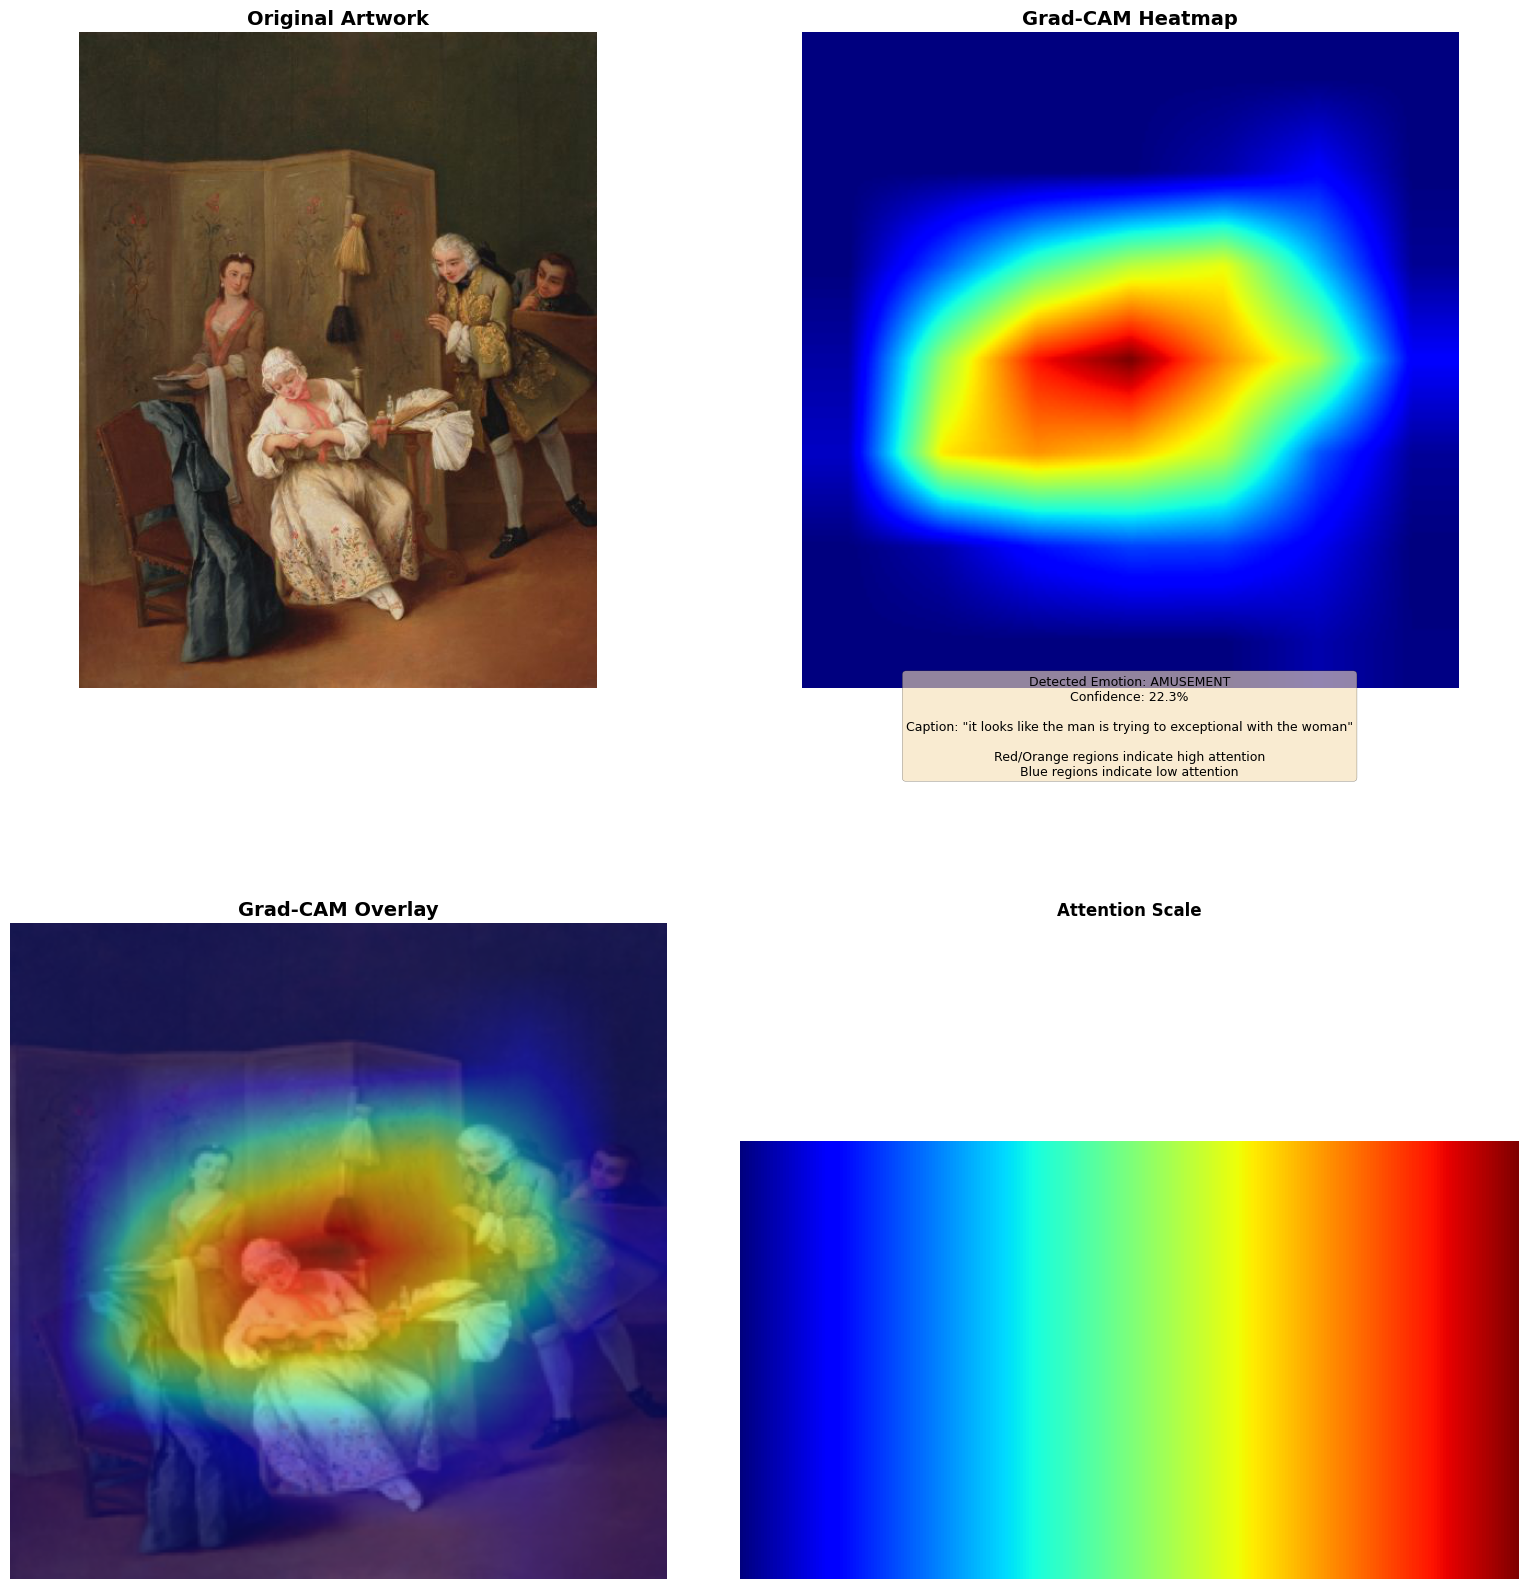

In [58]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))

axes[0, 0].imshow(image)
axes[0, 0].axis('off')
axes[0, 0].set_title('Original Artwork', fontsize=14, fontweight='bold')

axes[0, 1].imshow(cam_ensemble, cmap='jet')
axes[0, 1].axis('off')
axes[0, 1].set_title('Grad-CAM Heatmap', fontsize=14, fontweight='bold')

image_resized = image.resize((224, 224))
overlay = np.array(image_resized) / 255.0
heatmap_colored = plt.cm.jet(cam_ensemble)[:, :, :3]
overlay = overlay * 0.5 + heatmap_colored * 0.5

axes[1, 0].imshow(overlay)
axes[1, 0].axis('off')
axes[1, 0].set_title('Grad-CAM Overlay', fontsize=14, fontweight='bold')

cbar_ax = axes[1, 1]
cbar_ax.axis('off')
gradient = np.linspace(0, 1, 256).reshape(1, -1)
gradient_img = np.repeat(gradient, 50, axis=0)
cbar_ax.imshow(gradient_img, aspect='auto', cmap='jet', extent=[0, 1, 0, 1], origin='lower')
cbar_ax.set_xlim(0, 1)
cbar_ax.set_ylim(0, 1.5)
cbar_ax.set_xticks([0, 0.5, 1])
cbar_ax.set_xticklabels(['Low', 'Medium', 'High'])
cbar_ax.set_yticks([])
cbar_ax.set_title('Attention Scale', fontsize=12, fontweight='bold')

explanation = f"""Detected Emotion: {emotion_detected.upper()}
Confidence: {confidence:.1%}

Caption: \"{caption_generated}\"

Red/Orange regions indicate high attention
Blue regions indicate low attention"""
cbar_ax.text(0.5, 1.3, explanation, transform=cbar_ax.transAxes,
            ha='center', va='center', fontsize=9,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6))

plt.tight_layout()
plt.show()

## 11. Complete Analysis Report

In [44]:
print("="*80)
print("MULTIMODAL EMOTION ANALYSIS REPORT")
print("="*80)

print(f"\nArtwork: {sample_image_path.name}")
print(f"Style: {sample_image_path.parent.name}")
print(f"Size: {image.size}")

print("\n" + "="*80)
print("VISUAL CLASSIFICATION")
print("="*80)
print(f"\nDetected Emotion: {emotion_detected}")
print(f"Confidence: {confidence:.1%}")
print(f"\nTop-3 Predictions:")
for i, idx in enumerate(top3_indices, 1):
    print(f"  {i}. {EMOTION_LABELS[idx]:15s} {ensemble_probs[idx]:.1%}")

print("\n" + "="*80)
print("COLOR ANALYSIS")
print("="*80)
print(f"\nAverage LAB Values:")
print(f"  L* (Lightness): {avg_L:.1f}/100")
print(f"  a* (Green-Red): {avg_a:+.1f}")
print(f"  b* (Blue-Yellow): {avg_b:+.1f}")
print(f"  Chroma: {chroma:.1f}")

print("\n" + "="*80)
print("GENERATED CAPTION")
print("="*80)
print(f"\n\"{caption_generated}\"")
print(f"\nConditioned on: {emotion_detected}")

print("\n" + "="*80)
print("VISUAL EXPLANATION")
print("="*80)
print(f"\nGrad-CAM Statistics:")
print(f"  Min: {cam_ensemble.min():.3f}")
print(f"  Max: {cam_ensemble.max():.3f}")
print(f"  Mean: {cam_ensemble.mean():.3f}")

rosto_region = cam_ensemble[50:150, 80:150]
corpo_region = cam_ensemble[150:224, 50:180]
print(f"\nAttention Distribution:")
print(f"  Face region: {rosto_region.mean():.3f}")
print(f"  Body region: {corpo_region.mean():.3f}")

print("\n" + "="*80)

MULTIMODAL EMOTION ANALYSIS REPORT

Artwork: maurice-quentin-de-la-tour_face-of-the-man-after-alexis-grimou.jpg
Style: Rococo
Size: (697, 950)

VISUAL CLASSIFICATION

Detected Emotion: something else
Confidence: 20.3%

Top-3 Predictions:
  1. something else  20.3%
  2. amusement       16.5%
  3. disgust         14.8%

COLOR ANALYSIS

Average LAB Values:
  L* (Lightness): 30.7/100
  a* (Green-Red): +7.9
  b* (Blue-Yellow): +7.0
  Chroma: 10.5

GENERATED CAPTION

"i am hotel as to who this man is"

Conditioned on: something else

VISUAL EXPLANATION

Grad-CAM Statistics:
  Min: 0.000
  Max: 0.819
  Mean: 0.202

Attention Distribution:
  Face region: 0.109
  Body region: 0.312



## Summary

This notebook demonstrates a complete multimodal pipeline for artwork emotion analysis:

1. **Visual Classification**: Ensemble of 3 models achieves robust emotion detection
2. **Fuzzy Features**: Perceptually meaningful features extracted in LAB color space
3. **Caption Generation**: SAT generates emotion-conditioned explanatory captions
4. **Explainability**: Grad-CAM reveals visual attention patterns

**Key Advantages:**

- Visual-first classification avoids textual bias
- Emotion-conditioned captions explain detected emotions
- Grad-CAM provides interpretable visual explanations
- LAB color space ensures perceptually uniform feature extraction